In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
import glob
from PIL import Image
import cv2
import numpy as np
from datetime import datetime
import itertools
import pickle
import math
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import keras.backend as K

from sklearn.model_selection import train_test_split

In [2]:
%load_ext autoreload
%autoreload 2
from AnnotationData import AnnotationData
import models
import albumentations as A

In [40]:
folder = "D:/FER/diplomski_rad/data"
batch_size = 64
image_size = (128,128)

In [4]:
import glob
def loadAnnotation(input_folder):
    data = []
    paths = glob.glob(input_folder + "/**/*.pkl", recursive=True)
    for path in paths:
        with open(path, "rb") as file:
            annotations = pickle.load(file)
        annotationsArray = [(str(Path(path).parent) + "\\" + name, ant) for (name, ant) in annotations]
        data += annotationsArray
    return data

In [5]:
annotation = loadAnnotation(folder)

In [6]:
annotation[0]

('D:\\FER\\diplomski_rad\\data\\studentidmatrix-dataset01\\dataset01\\p0000001.png',
 array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]], dtype=int8))

In [7]:
len(annotation)

1709

In [28]:
train_annotation, val_annotation = train_test_split(annotation, test_size=0.3,random_state=1)

In [99]:
import random 

import cv2
import numpy as np 
import math

class Dataset(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size, image_size, transform = None):
        self.image_size = image_size
        self.data = data
        self.batch_size = batch_size
        self.transform = transform

    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, idx):
        batch_data = self.data[idx * self.batch_size: (idx + 1) * self.batch_size]
        images = np.array([self.load_image(name) for (name, ant) in batch_data], dtype=np.float32)
        annotation = np.array([np.expand_dims(ant.astype(np.float32), -1) for (name, ant) in batch_data])
        return images, annotation 
    
    def on_epoch_end(self):
        random.shuffle(self.data)
            
    def load_image(self, path, transform=None):
        img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, self.image_size, interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32) / 255.0
        if self.transform is not None:
            img = self.transform(image=img)["image"]
        img = np.expand_dims(img, axis=-1)
        return img
 

In [13]:
AnnotationData.convertAnnotationToStr(train_dataset[0][1][0])

'0036519064'

In [15]:
a = np.array([
     [1, 1, 0, 0, 0, 0, 0, 0, 0, 1],
     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
     [0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
     ])

In [100]:
import copy
print(AnnotationData.convertAnnotationToStr(a))
a1 = copy.deepcopy(a)
a1[6,0] = 1
a1[8,0] = 1
print(AnnotationData.convertAnnotationToStr(a1))
a2 = copy.deepcopy(a)
a2[0,0] = 0
print(AnnotationData.convertAnnotationToStr(a2))

0036519620
[068]036519620
X036519620


In [17]:
stop = False
for i,batch in enumerate(train_dataset[0]):
    for j, ant in enumerate(batch):
        name = AnnotationData.convertAnnotationToStr(ant)
        if "[" in name:
            print(i,j)
            stop = True
    
    if stop: break
            


0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31


In [156]:
import cv2
import albumentations as A
train_transform = A.Compose([
    A.Rotate(limit=(-6,6), p=0.4,mask_value=1),
    A.ShiftScaleRotate(p=0.3, shift_limit=0.0, scale_limit=0.1, rotate_limit=0, mask_value=1, border_mode=cv2.BORDER_CONSTANT, value=1),
    A.ShiftScaleRotate(p=0.3, shift_limit=0.1, scale_limit=0.00, rotate_limit=0, mask_value=1, border_mode=cv2.BORDER_CONSTANT, value=1)
])

In [157]:
org_prob = 0.5
from scipy import optimize
probabilities = [ t.p for t in train_transform]
p = lambda x: abs( np.prod([1- x * p for p in probabilities]) -  org_prob)
minimum = optimize.golden(p, brack=(0, 1e-6)) #1 / max(probabilities)
print("Optimization factor", minimum)
for t in train_transform:
    new_p = t.p * minimum
    if new_p < 0 or new_p > 1:
        raise ValueError("new P is outside of probability limits, new_p = "+ str(new_p))
    t.p = new_p

print("Adjusted probablities" ,[ str(t.p) for t in train_transform])

Optimization factor 0.6172705889627702
Adjusted probablities ['0.2469082355851081', '0.18518117668883105', '0.18518117668883105']


In [112]:
from sklearn.model_selection import KFold

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=1)
fold_datasets = []
folds = kf.split(annotation)
for fold, (train_indices, test_indices) in enumerate(folds):
    train_data = [annotation[i] for i in train_indices]
    test_data = [annotation[i] for i in test_indices]
    train_dataset = Dataset(train_data, batch_size, image_size, transform=train_transform)
    test_dataset = Dataset(test_data, batch_size, image_size)
    fold_datasets.append((train_dataset, test_dataset))

In [74]:
train_dataset = Dataset(train_annotation, batch_size, image_size)
val_dataset = Dataset(val_annotation, batch_size, image_size)

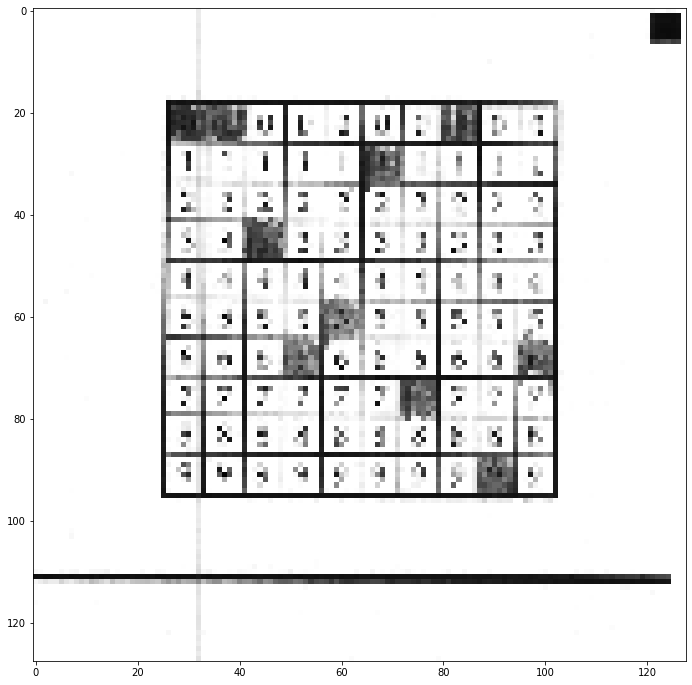

In [75]:
train_dataset[0][0][0]
fig = plt.figure(figsize=(12., 12.))
plt.imshow(train_dataset[0][0][0][...,-1], cmap=plt.get_cmap('gray'))

In [143]:
import cv2
import albumentations as A
train_transform_test = A.Compose([   
    A.Rotate(limit=(-6,6), p=1,mask_value=1),
    A.ShiftScaleRotate(p=1, shift_limit=0.0, scale_limit=0.1, rotate_limit=0, mask_value=1, border_mode=cv2.BORDER_CONSTANT, value=1),
    A.ShiftScaleRotate(p=1, shift_limit=0.1, scale_limit=0.00, rotate_limit=0, mask_value=1, border_mode=cv2.BORDER_CONSTANT, value=1)
])

In [144]:
import random
whole_dataset = Dataset(annotation, batch_size, (256, 256), transform=train_transform_test)
whole_dataset_without = Dataset(annotation, batch_size, (256, 256))
batch = random.randint(0, len(whole_dataset))

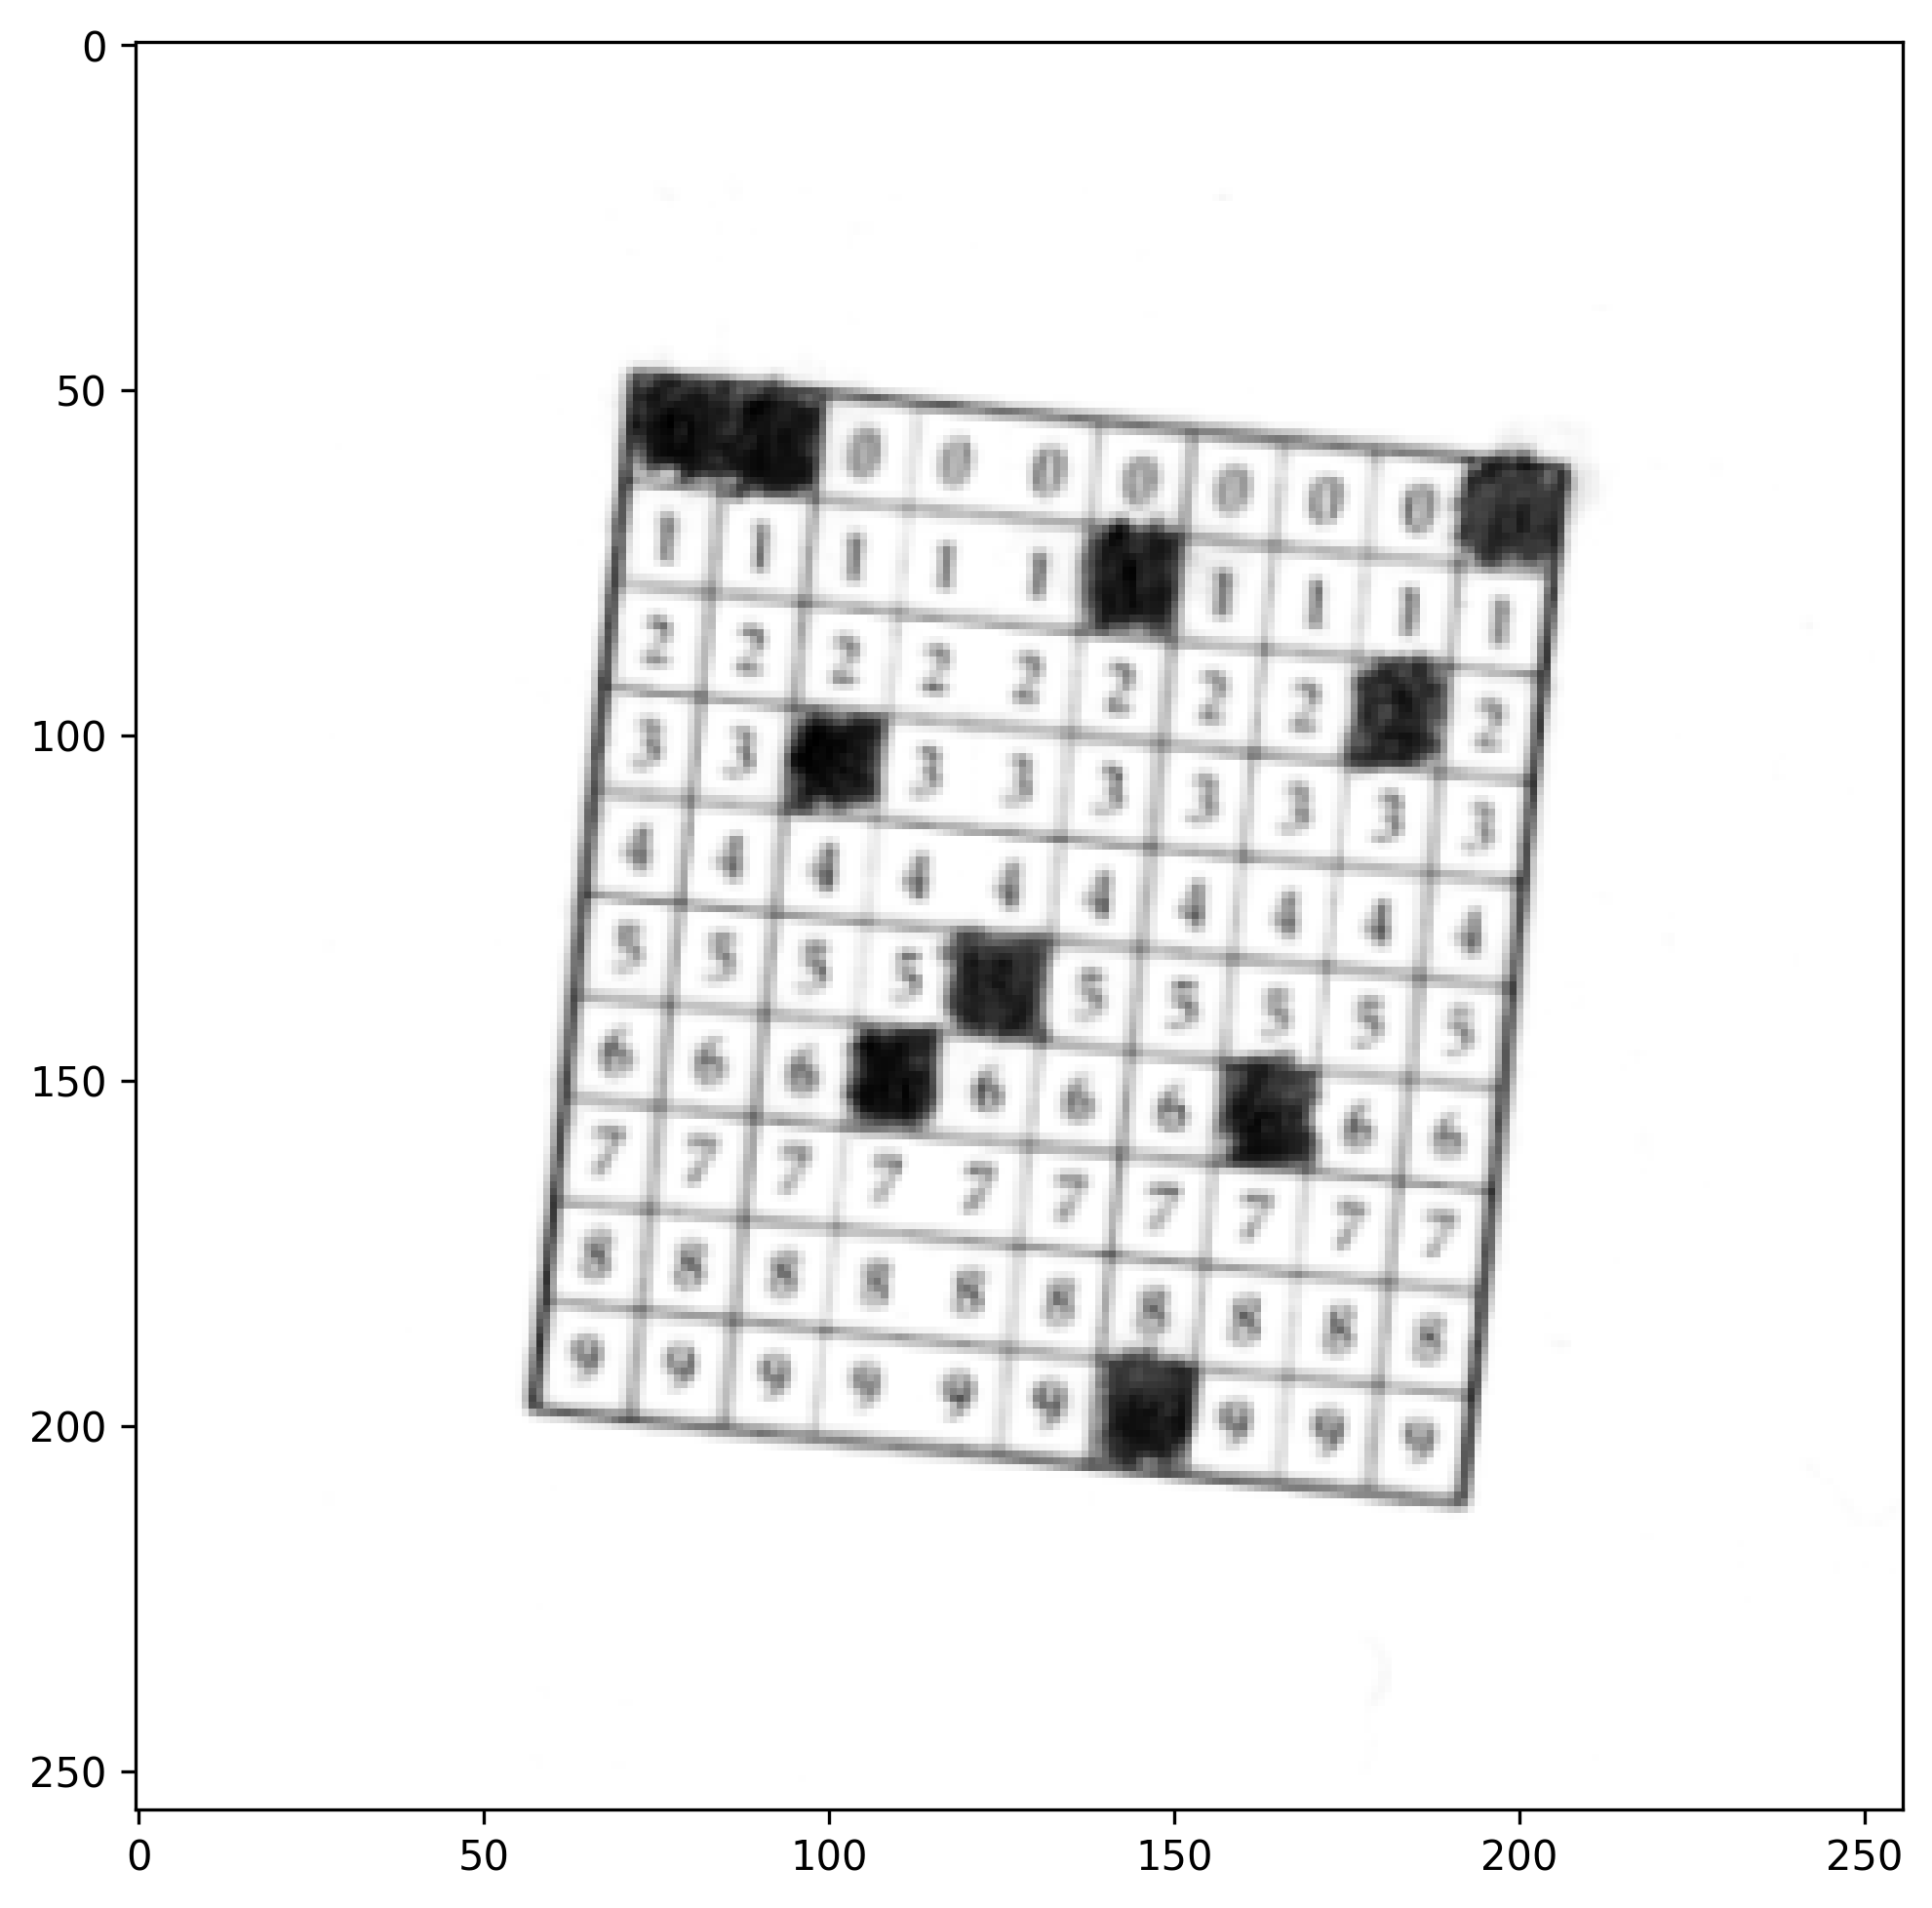

In [148]:
from matplotlib.pyplot import figure

figure(figsize=(8, 8), dpi=300)
plt.imshow(whole_dataset[0][0][0][...,-1], cmap = "gray")

In [14]:
annotation[0]

('D:\\FER\\IstrazivackiSeminar\\data\\studentidmatrix-dataset01\\dataset01\\p0000001.png',
 array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]], dtype=int8))

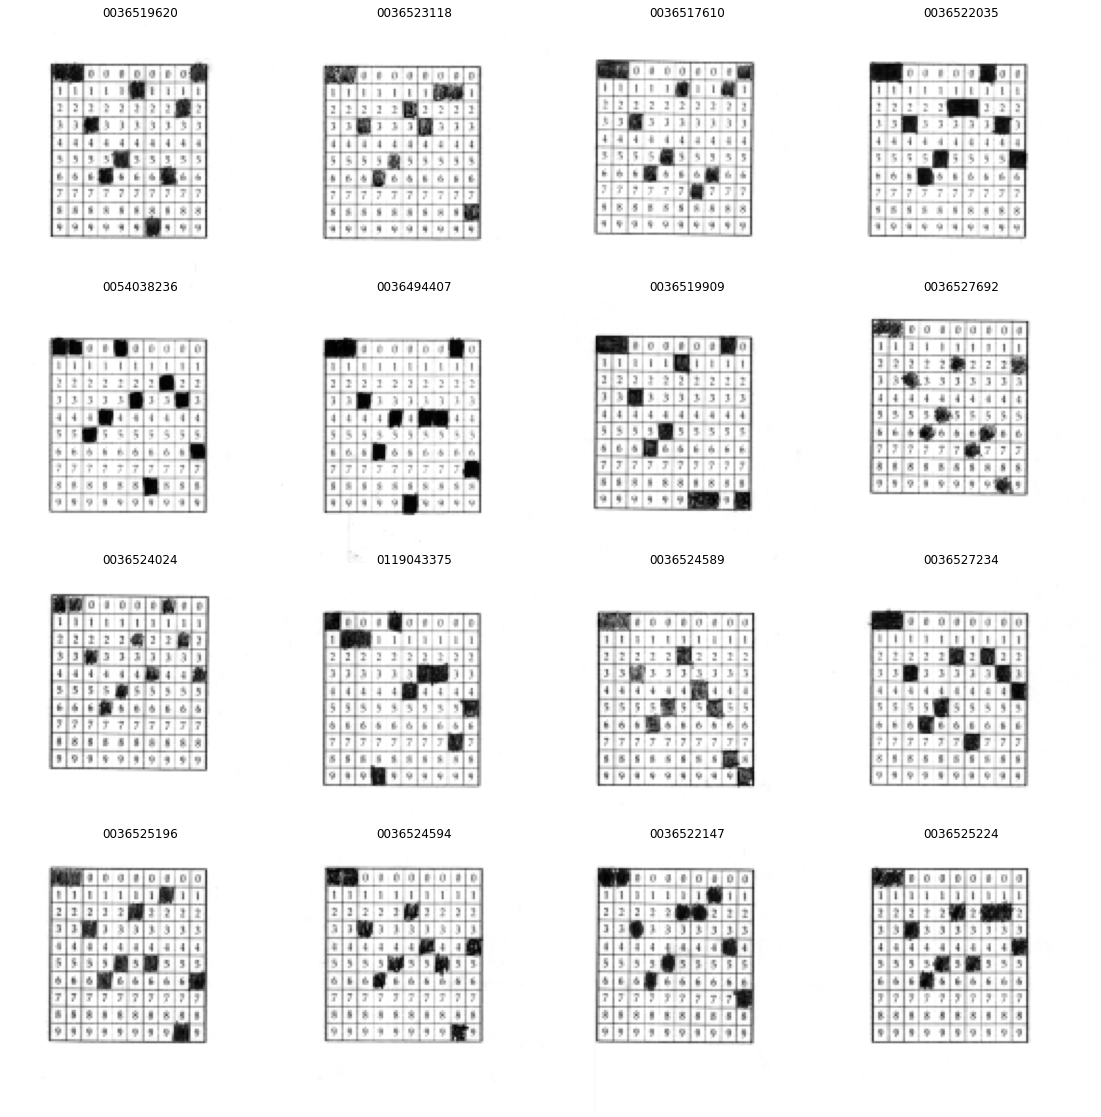

In [26]:
data = whole_dataset[batch][:][:16]
fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),
                 axes_pad=0.1 
                 )

for ax, im,ant in zip(grid, data[0], data[1]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im[...,-1], cmap = "gray")
    ax.set_title(AnnotationData.convertAnnotationToStr(ant[...,-1]))
    ax.axis("off")

plt.show()

In [378]:
train_dataset[0][1][7][...,0].astype(np.int)

C:\Users\Filip\AppData\Local\Temp\ipykernel_7804\564435195.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_dataset[0][1][7][...,0].astype(np.int)


array([[1, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [379]:
AnnotationData.convertAnnotationToStr(train_dataset[0][1][7])

'00[36][15]X8[08]5XX'

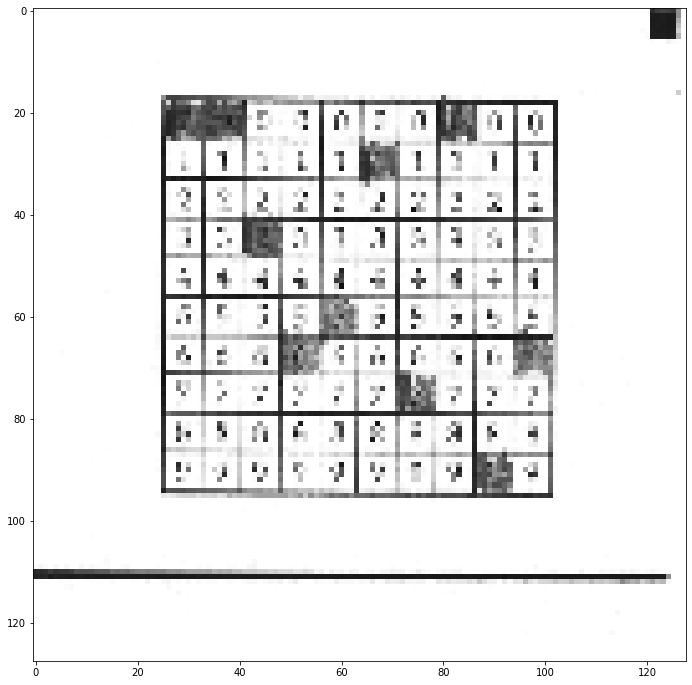

In [69]:
train_dataset[0][0][0]
fig = plt.figure(figsize=(12., 12.))
plt.imshow(train_dataset[0][0][0][...,-1], cmap=plt.get_cmap('gray'))

In [83]:
def absolute_accuracy(y_true, y_pred, round_value = 0.5):
    y_pred = tf.where(tf.greater(y_pred, round_value), tf.ones_like(y_pred), tf.zeros_like(y_pred))
    equal = tf.equal(y_true, y_pred)
    result = tf.cast(tf.reduce_all(equal, axis=[1, 2, 3]), tf.int8)
    return result

In [65]:
class Beta_Accuracy(tf.keras.metrics.Metric):

  def __init__(self, name='beta_accuracy', **kwargs):
    super().__init__(name=name, **kwargs)
    self.accuracy = self.add_weight(name='accuracy', initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight=None):
    reduce_sum = tf.reduce_sum(y_true, axis=[1, -1])
    indexes = tf.where(tf.reduce_all(tf.equal(reduce_sum, 1), axis=1))
    values = absolute_accuracy(y_true[indexes], y_pred[indexes])
    if sample_weight is not None:
      sample_weight = tf.cast(sample_weight, self.dtype)
      values = tf.multiply(values, sample_weight[indexes])
    self.accuracy.assign_mean(tf.reduce_mean(values))

  def result(self):
    return self.accuracy

  def reset_states(self):
    self.accuracy.assign(0)

m = Beta_Accuracy()
m.update_state([0, 1, 1, 1], [0, 1, 0, 0])
print('Intermediate result:', float(m.result()))

m.update_state([1, 1, 1, 1], [0, 1, 1, 0])
print('Final result:', float(m.result()))

Intermediate result: 1.0
Final result: 3.0


In [15]:
def absolute_accuracy_on_correct(y_true, y_pred):
    reduce_sum = tf.reduce_sum(y_true, axis=[1, -1])
    indexes = tf.where(tf.reduce_all(tf.equal(reduce_sum, 1), axis=1))
    return absolute_accuracy(y_true[indexes], y_pred[indexes])

In [133]:
class Beta_Accuracy():

  def __init__(self, name='beta_accuracy', **kwargs):
    super().__init__(name=name, **kwargs)
    self.sum = 0
    self.count = 0

  def update_state(self, y_true, y_pred, sample_weight=None):
    reduce_sum = tf.reduce_sum(y_true, axis=[1, -1])
    indexes = tf.where(tf.reduce_all(tf.equal(reduce_sum, 1), axis=1))
    values = tf.cast(absolute_accuracy(y_true[indexes], y_pred[indexes]), tf.float32)
    if sample_weight is not None:
      sample_weight = tf.cast(sample_weight, self.dtype)
      values = tf.multiply(values, sample_weight[indexes])
    self.sum += tf.reduce_sum(values)
    self.count += len(values)

  def result(self):
    return self.sum / self.count

  def reset_states(self):
    self.sum = 0
    self.count = 0

beta_accuracy = Beta_Accuracy()


In [143]:
class Alpha_Accuracy():

  def __init__(self, name='alpha_accuracy', **kwargs):
    super().__init__(name=name, **kwargs)
    self.sum = self.add_weight(name='sum', initializer='zeros')
    self.count = self.add_weight(name='count', initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred_round = tf.round(y_pred)
    reduce_sum = tf.reduce_sum(y_pred_round, axis=[1, -1])
    indexes = tf.squeeze(tf.where(tf.reduce_all(tf.equal(reduce_sum, 1), axis=1)))
    values = absolute_accuracy(y_true[indexes], y_pred[indexes])
    if sample_weight is not None:
      sample_weight = tf.cast(sample_weight, values.dtype)
      values *= sample_weight[indexes]
    self.sum.assign_add(tf.reduce_sum(values))
    self.count.assign_add(tf.cast(tf.shape(values)[0], self.dtype))

  def result(self):
    return self.sum / self.count

  def reset_states(self):
    self.sum.assign(0)
    self.count.assign(0)

alpha_accuracy = Alpha_Accuracy()

In [16]:
labels = np.array(list(itertools.chain(*[x[1] for x in whole_dataset])))

NameError: name 'whole_dataset' is not defined

In [366]:
reduce_sum = tf.reduce_sum(labels, axis=[1, -1])
indexes = tf.where(tf.reduce_all(tf.equal(reduce_sum, 1), axis=1))
len(labels), len(indexes)

(1709, 1658)

In [113]:
from keras.callbacks import LearningRateScheduler

# This is a sample of a scheduler I used in the past
def lr_scheduler(epoch, lr):
    decay_rate = 0.9
    decay_step = 20
    if epoch % decay_step == 0 and epoch:
        return lr * pow(decay_rate, np.floor(epoch / decay_step))
    return lr

In [4]:
import numpy as np
import tensorflow as tf
y_true = [
    [
        [[1],[0]],
        [[0],[0]],
    ],
    [
        [[1],[0]],
        [[0],[1]],
    ],
    [
        [[0],[1]],
        [[1],[1]],
    ],
]
y_pred = [
    [
        [[0.93],[0.1]],
        [[0],[0.2]],
    ],
    [
        [[0.3],[0.3]],
        [[0.6],[1.]],
    ],
    [
        [[0.00000001],[0.9999999]],
        [[0.999999999],[0.000001]],
    ],
]
print("Shape", np.array(y_true).shape)
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False,axis=-1)
bce(y_true, y_pred).numpy()

Shape (3, 2, 2, 1)


1.3831844

In [114]:
callbacks = [LearningRateScheduler(lr_scheduler, verbose=1)]


In [132]:

model = models.model(image_size, in_channels=1,out_channels=1,channels=[32, 32, 64, 128], final_channel=16, dropout=0.1) #[64, 64, 128, 256]
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 128, 128, 32) 832         input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_26 (LeakyReLU)      (None, 128, 128, 32) 0           conv2d_28[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_14 (MaxPooling2D) (None, 64, 64, 32)   0           leaky_re_lu_26[0][0]             
______________________________________________________________________________________________

In [134]:
opt = optimizers.Adam(learning_rate=0.0015, clipnorm = 0.1)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[absolute_accuracy])

In [136]:
history = model.fit(fold_datasets[0][0],validation_data=fold_datasets[0][1], epochs=150, callbacks=callbacks)

Epoch 1/150

Epoch 00001: LearningRateScheduler setting learning rate to 0.001500000013038516.
22/22 [==============================] - 26s 681ms/step - loss: 0.3401 - absolute_accuracy: 0.0066 - val_loss: 0.1905 - val_absolute_accuracy: 0.0000e+00
Epoch 2/150

Epoch 00002: LearningRateScheduler setting learning rate to 0.001500000013038516.
22/22 [==============================] - 6s 250ms/step - loss: 0.1835 - absolute_accuracy: 0.0000e+00 - val_loss: 0.2272 - val_absolute_accuracy: 0.0000e+00
Epoch 3/150

Epoch 00003: LearningRateScheduler setting learning rate to 0.001500000013038516.
22/22 [==============================] - 5s 245ms/step - loss: 0.1788 - absolute_accuracy: 0.0000e+00 - val_loss: 0.1843 - val_absolute_accuracy: 0.0000e+00
Epoch 4/150

Epoch 00004: LearningRateScheduler setting learning rate to 0.001500000013038516.
22/22 [==============================] - 6s 283ms/step - loss: 0.1732 - absolute_accuracy: 0.0000e+00 - val_loss: 0.1689 - val_absolute_accuracy: 0.0000

In [135]:
model.save('test_model.h5')

In [131]:
channels = [64, 64, 128, 256]
last_channel = 32

In [132]:
metrics = []

In [133]:

for i in range(5):
    print("Fold", i)
    model = models.model(image_size, 1,1,channels=channels, last_channel=last_channel, dropout=0.1,batch_normalization=False)
    opt = optimizers.Adam(learning_rate=0.0015, clipnorm = 0.1)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[absolute_accuracy])
    tr_dat1, val_dat1 = fold_datasets[i]
    history = model.fit(tr_dat1,validation_data=val_dat1, epochs=150,shuffle=True, callbacks=callbacks)

    all_pred = np.array(list(itertools.chain(*[model.predict(x[0]) for x in val_dat1])))
    all_true = np.array(list(itertools.chain(*[x[1] for x in val_dat1])))


    alpha_accuracy = Alpha_Accuracy()
    alpha_accuracy.update_state(all_true, all_pred)
    alpha = float(alpha_accuracy.result())
    print('alpha_accuracy result:', alpha)
    beta_accuracy = Beta_Accuracy()
    beta_accuracy.update_state(all_true, all_pred)
    beta = float(beta_accuracy.result())
    print('beta_accuracy result:', beta)
    result = [channels, last_channel, i, history.history['val_absolute_accuracy'][-1], alpha, beta]
    metrics.append(result)


Fold 0
Epoch 1/150

Epoch 00001: LearningRateScheduler setting learning rate to 0.001500000013038516.
22/22 [==============================] - 18s 580ms/step - loss: 1.8035 - absolute_accuracy: 0.0029 - val_loss: 0.3706 - val_absolute_accuracy: 0.0029
Epoch 2/150

Epoch 00002: LearningRateScheduler setting learning rate to 0.001500000013038516.
22/22 [==============================] - 7s 307ms/step - loss: 0.2689 - absolute_accuracy: 0.0022 - val_loss: 0.1879 - val_absolute_accuracy: 0.0000e+00
Epoch 3/150

Epoch 00003: LearningRateScheduler setting learning rate to 0.001500000013038516.
22/22 [==============================] - 7s 308ms/step - loss: 0.1904 - absolute_accuracy: 7.3153e-04 - val_loss: 0.1850 - val_absolute_accuracy: 0.0000e+00
Epoch 4/150

Epoch 00004: LearningRateScheduler setting learning rate to 0.001500000013038516.
22/22 [==============================] - 7s 309ms/step - loss: 0.1923 - absolute_accuracy: 0.0000e+00 - val_loss: 0.1732 - val_absolute_accuracy: 0.0000e

In [134]:
metrics

[[[64, 64, 128, 256], 32, 0, 0.988304078578949, 1.0, 0.9939939975738525],
 [[64, 64, 128, 256],
  32,
  1,
  0.9707602262496948,
  0.9939209818840027,
  0.9849397540092468],
 [[64, 64, 128, 256],
  32,
  2,
  0.9649122953414917,
  0.9908536672592163,
  0.9878419637680054],
 [[64, 64, 128, 256],
  32,
  3,
  0.9619883298873901,
  0.9908257126808167,
  0.9759036302566528],
 [[64, 64, 128, 256], 32, 4, 0.9765396118164062, 1.0, 0.9878787994384766]]

In [135]:
L_model_metric = np.array([[i[3], i[4], i[5]] for i in metrics])

In [137]:
np.round(L_model_metric.mean(axis=0),4) 

array([0.9725, 0.9951, 0.9861])

In [108]:
M_model_metric = np.array([[i[3], i[4], i[5]] for i in metrics])

In [112]:
np.round(1 - M_model_metric.mean(axis=0),4) 

array([0.0333, 0.0049, 0.0181])

In [119]:
S_model_metric = np.array([[i[3], i[4], i[5]] for i in metrics])

In [121]:
np.round(1 - S_model_metric.mean(axis=0),4) 

array([0.0503, 0.0062, 0.0344])

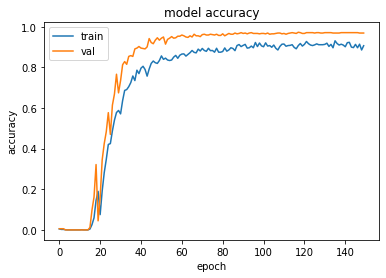

In [43]:
plt.plot(history.history['absolute_accuracy'])
plt.plot(history.history['val_absolute_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [49]:
history.history['val_absolute_accuracy'][-1]


0.9032257795333862

In [28]:
data = val_dataset[0]
prediction = (model.predict(data[0]) > 0.5).astype(np.int8)
#absolute_accuracy(data[1], prediction)
for y_pred, y_true in zip(prediction, data[1]):
    y_pred_str = AnnotationData.convertAnnotationToStr(y_pred[...,-1])
    y_true_str = AnnotationData.convertAnnotationToStr(y_true[...,-1])
    print(f"y_pred: {y_pred_str}, y_true: {y_true_str}")


y_pred: 0036514533, y_true: 0036514533
y_pred: 0036514666, y_true: 0036514666
y_pred: 0036514101, y_true: 0036514101
y_pred: 0036514351, y_true: 0036514351
y_pred: 0036516270, y_true: 0036516270
y_pred: 00365X1019, y_true: 0036511019
y_pred: 00X3X65XXX, y_true: 00X3X65XXX
y_pred: 0036513723, y_true: 0036513723
y_pred: 0036544793, y_true: 0036544793
y_pred: 0036516057, y_true: 0036516057
y_pred: 0036518207, y_true: 0036518207
y_pred: 0036513653, y_true: 0036513653
y_pred: 0036517353, y_true: 0036517353
y_pred: 0036517743, y_true: 0036517743
y_pred: 0036514624, y_true: 0036514624
y_pred: 0036519379, y_true: 0036519379
y_pred: 0036515023, y_true: 0036515023
y_pred: 0036516309, y_true: 0036516309
y_pred: 0036514650, y_true: 0036514650
y_pred: 0036523256, y_true: 0036523256
y_pred: 0036515156, y_true: 0036515156
y_pred: 0036522077, y_true: 0036522077
y_pred: 0036517668, y_true: 0036517668
y_pred: 0036513723, y_true: 0036513723
y_pred: 0036523529, y_true: 0036523529
y_pred: 0036508464, y_tru

In [28]:
data[0].shape

(32, 128, 128, 1)

In [30]:
class Alpha_Accuracy():

  def __init__(self, name='beta_accuracy', **kwargs):
    #super().__init__(name=name, **kwargs)
    self.sum = 0
    self.count = 0

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred_round = tf.round(y_pred)
    reduce_sum = tf.reduce_sum(y_pred_round, axis=[1, -1])
    indexes = tf.squeeze(tf.where(tf.reduce_all(tf.equal(reduce_sum, 1), axis=1)))
    values = tf.cast(absolute_accuracy(y_true[indexes], y_pred[indexes]), tf.float32)
    if sample_weight is not None:
      sample_weight = tf.cast(sample_weight, self.dtype)
      values = tf.multiply(values, sample_weight[indexes])
    self.sum += tf.reduce_sum(values)
    self.count += len(values)

  def result(self):
    return self.sum / self.count

  def reset_states(self):
    self.sum = 0
    self.count = 0



In [31]:
class Beta_Accuracy():

  def __init__(self, name='beta_accuracy', **kwargs):
    #super().__init__(name=name, **kwargs)
    self.sum = 0
    self.count = 0

  def update_state(self, y_true, y_pred, sample_weight=None):
    reduce_sum = tf.reduce_sum(y_true, axis=[1, -1])
    indexes = tf.squeeze(tf.where(tf.reduce_all(tf.equal(reduce_sum, 1), axis=1)))
    values = tf.cast(absolute_accuracy(y_true[indexes], y_pred[indexes]), tf.float32)
    if sample_weight is not None:
      sample_weight = tf.cast(sample_weight, self.dtype)
      values = tf.multiply(values, sample_weight[indexes])
    self.sum += tf.reduce_sum(values)
    self.count += len(values)

  def result(self):
    return self.sum / self.count

  def reset_states(self):
    self.sum = 0
    self.count = 0



In [125]:
whole_dataset[26][0].shape

(45, 128, 128, 1)

In [124]:
len(whole_dataset)

27

In [122]:

all_pred = np.array(list(itertools.chain(*[model.predict(x[0]) for x in whole_dataset])))
all_true = np.array(list(itertools.chain(*[x[1] for x in whole_dataset])))

In [126]:
all_pred.shape

(1709, 10, 10, 1)

In [130]:
m = Alpha_Accuracy()
m.update_state(all_true, all_pred)
print('Intermediate result:', 1 -float(m.result()))



Intermediate result: 0.0030303001403808594


In [122]:
reduce_sum = tf.reduce_sum(all_true, axis=[1, -1])
indexes = tf.squeeze(tf.where(tf.reduce_all(tf.equal(reduce_sum, 1), axis=1)))

not_alfpa = np.array(list(set(list(range(len(indexes)))).difference(set(indexes.numpy()))))
not_alfpa

array([448,   6,  73, 426,  76, 428,  78, 176, 149, 470, 151,  26, 247])

In [500]:
train_val_dataset = Dataset(train_annotation, batch_size, image_size)
all_pred_train = np.array(list(itertools.chain(*[model.predict(x[0]) for x in train_val_dataset])))
all_true_train = np.array(list(itertools.chain(*[x[1] for x in train_val_dataset])))

In [127]:
val_acc = absolute_accuracy(all_true, all_pred).numpy()

In [ ]:
val_acc

In [129]:
len(val_acc) , val_acc.sum(),  val_acc.sum() / len(val_acc) 

(1709, 1690, 0.9888823873610298)

In [501]:
train_acc = absolute_accuracy(all_true_train, all_pred_train).numpy()

In [502]:
len(train_acc) , train_acc.sum()

(1196, 1196)

In [503]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False,axis =[1,2,3], reduction=tf.keras.losses.Reduction.NONE)
all_loss = bce(all_true_train, all_pred_train).numpy()

In [123]:
index_to_show = not_alfpa[0:12]
index_to_show

array([448,   6,  73, 426,  76, 428,  78, 176, 149, 470, 151,  26])

In [131]:
index_to_show = val_acc.argsort()[:20]
index_to_show

array([  30, 1675,  301,  302,  194,  305,   94, 1352,  201,  662,  204,
        629, 1672, 1333,  268,  555,  535, 1335,  547, 1147], dtype=int64)

In [149]:
all_pred[1069].max()

0.48419937

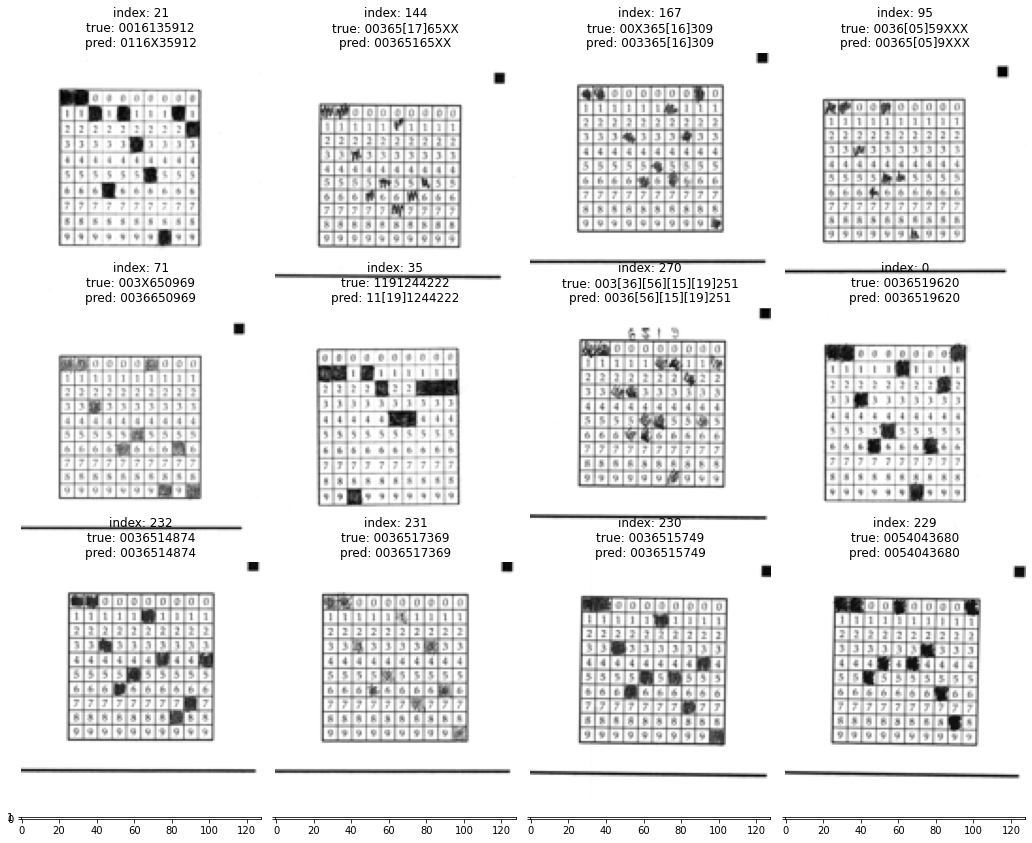

In [149]:
fig = plt.figure(figsize=(18., 18.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),
                 axes_pad=0.2 
                 )

for ax, index in zip(grid, index_to_show):
    # Iterating over the grid returns the Axes.
    ax.imshow(fold_datasets[0][1][index // batch_size][0][index % batch_size], cmap = "gray")
    true_str = AnnotationData.convertAnnotationToStr(fold_datasets[0][1][index // batch_size][1][index % batch_size])
    pred_str = AnnotationData.convertAnnotationToStr(all_pred[index].round())
    ax.set_title(f"index: {index}\ntrue: {true_str}\npred: {pred_str}")
    ax.axis("off")

plt.show()

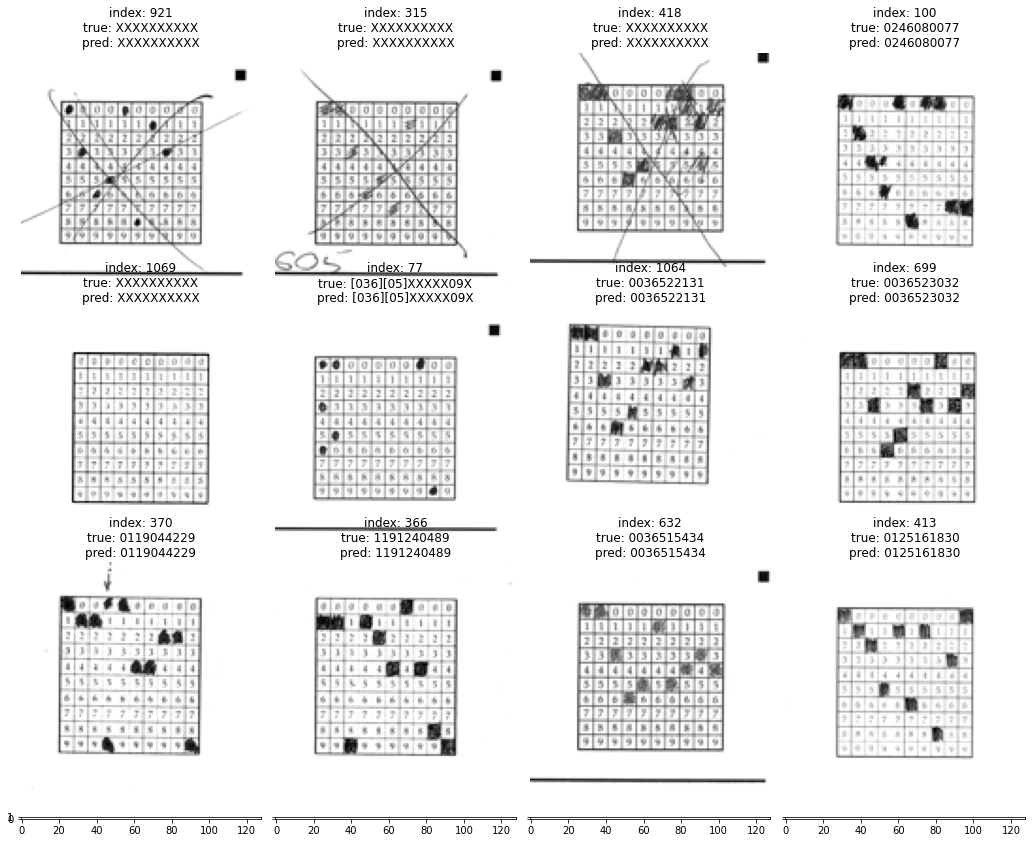

In [508]:
fig = plt.figure(figsize=(18., 18.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),
                 axes_pad=0.2 
                 )

for ax, index in zip(grid, index_to_show):
    # Iterating over the grid returns the Axes.
    ax.imshow(train_val_dataset[index // batch_size][0][index % batch_size], cmap = "gray")
    true_str = AnnotationData.convertAnnotationToStr(train_val_dataset[index // batch_size][1][index % batch_size])
    pred_str = AnnotationData.convertAnnotationToStr(all_pred_train[index].round())
    ax.set_title(f"index: {index}\ntrue: {true_str}\npred: {pred_str}")
    ax.axis("off")

plt.show()

In [490]:
train_annotation[438]

('D:\\FER\\IstrazivackiSeminar\\studentidmatrix-dataset04\\dataset04\\p0000030.png',
 array([[1, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]], dtype=int8))